# COMPARING TF-IDF VARIANTS FOR RECEIPT RECOGNITION

# Notebook Outline
## I. Imports Section
## II. Utility Functions
## III. Load Data
## IV. Vectorise Data
## V. Normalization and Dimensionality Reduction
## VI. Label Encoding
## VII. Data Exploration and Cleaning
## VIII. Model Building and Evaluation

## I. Imports Section

In [1]:
# TF IDF
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import regularizers
from keras.models import load_model
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## II. Utility Functions

In [2]:
def preprocess_text(text):
  # remove special characters
  text = re.sub(r'[^a-zA-Z\s]+','',text)

  #tokenize
  output1 = word_tokenize(text)

  # remove stop words
  stop_words = set(stopwords.words('english'))
  output2 = [word for word in output1 if word.lower() not in stop_words]

  # stemming
  stemmer = SnowballStemmer('english')
  output3 = [stemmer.stem(word) for word in output2]

  return " ".join(output3)

In [3]:
def vectorize_tfidf(variant, data):
  # change variant to lowercase
  variant = variant.lower()

  # initialise vectorizer
  v = TfidfVectorizer(sublinear_tf=False, use_idf=False, norm = None, smooth_idf = False)

  # Switch parameters based on flavours
  if variant == "nnn":
    pass
  elif variant == "ntn":
    v.use_idf = True
    pass
  elif variant == "ntc":
    v.use_idf = True
    v.norm = "l2"
    pass
  elif variant == "lnn":
    v.sublinear_tf = True
    pass
  elif variant == "ltn":
    v.sublinear_tf = True
    v.use_idf = True
    pass
  elif variant == "ltc":
    v.sublinear_tf = True
    v.use_idf = True
    v.norm = "l2"
    pass
  elif variant == "bnn":
    v.binary = True
  elif variant == "btn":
    v.binary = True
    v.use_idf = True
    pass
  elif variant == "btc":
    v.binary = True
    v.use_idf = True
    v.norm="l2"
    pass
  else:
    print(f"Variant {variant} Not supported")
    return None, None

  tfidf = v.fit_transform(data).todense()

  return tfidf, v

## III. Load Data




In [4]:
df = pd.read_csv("34.csv", header=None)

X_train, X_test, y_train, y_test = train_test_split(df[0],df[2], test_size=0.2, train_size=0.8, random_state=1, stratify=df[2])
X_train_clean = X_train.apply(preprocess_text)
X_test_clean = X_test.apply(preprocess_text)

#one hot encode y
y_train_ohe = pd.get_dummies(y_train, drop_first=False)
y_test_ohe = pd.get_dummies(y_test, drop_first=False)

# print(X_train.head(3))
# print(X_train_clean.head(3))
# y_train_ohe

## IV. Vectorise Data

In [5]:
# Vectorize data
variant_sm = "btc"
X_train_tfidf, v = vectorize_tfidf(variant_sm, X_train_clean)
X_test_tfidf = v.transform(X_test_clean).todense()
# print(f"Variant: {variant_sm}")
# print(X_test_tfidf[:10])

## V. Normalization and Dimensionality Reduction

In [6]:
# Normalization
n = Normalizer(norm='l2')
X_train_n = n.fit_transform(np.asarray(X_train_tfidf))
x_test_n = n.transform(np.asarray(X_test_tfidf))

print(type(x_test_n))

<class 'numpy.ndarray'>


In [7]:
# Dimensionality reduction
n_components = 1000
svd = TruncatedSVD(n_components=n_components)
x_train_svd = svd.fit_transform(X_train_n)
x_test_svd = svd.transform(x_test_n)
# x_test_svd[0:10]

In [8]:
sum(svd.explained_variance_ratio_)

0.7361469509400286

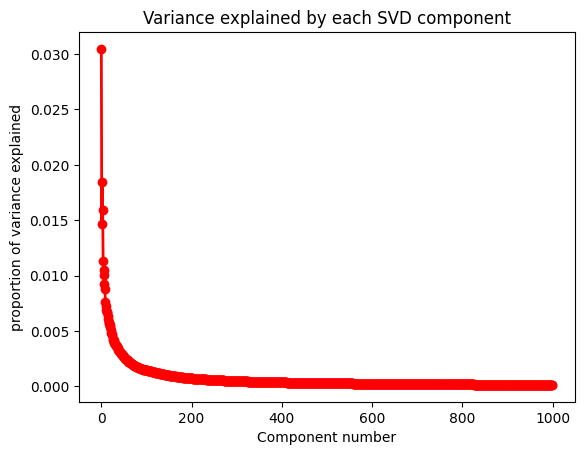

In [9]:
import matplotlib.pyplot as plt
plt.plot(svd.explained_variance_ratio_, 'ro-', linewidth=2)
plt.xlabel("Component number")
plt.ylabel("proportion of variance explained")
plt.title("Variance explained by each SVD component")
plt.show()


## VI. Label Encoding

In [10]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder on y and transform y
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

# Verify the unique classes in y
print(np.unique(y_train))
print(np.unique(y_test))
print(np.unique(y_train_le))
print(np.unique(y_test_le))

['CPUs' 'Digital Cameras' 'Dishwashers' 'Freezers' 'Fridge Freezers'
 'Fridges' 'Microwaves' 'Mobile Phones' 'TVs' 'Washing Machines']
['CPUs' 'Digital Cameras' 'Dishwashers' 'Freezers' 'Fridge Freezers'
 'Fridges' 'Microwaves' 'Mobile Phones' 'TVs' 'Washing Machines']
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


## VII. Data Exploration and Cleaning

In [11]:
# find missing values in column 0
missing_col0 = df.iloc[:, 0].isna().sum()
print(f"Missing values in column 0: {missing_col0}")

# find missing values in column 1
missing_col1 = df.iloc[:, 1].isna().sum()
print(f"Missing values in column 1: {missing_col1}")

# find missing values in column 2
missing_col2 = df.iloc[:, 2].isna().sum()
print(f"Missing values in column 2: {missing_col2}")

Missing values in column 0: 0
Missing values in column 1: 0
Missing values in column 2: 0


In [12]:
num_unique_categories = df.iloc[:, 2].nunique()
print(f"Number of unique categories: {num_unique_categories}")

Number of unique categories: 10


In [13]:
unique_categories = df.iloc[:, 2].unique().tolist()
num_unique_categories = len(unique_categories)

print(f"Number of unique categories: {num_unique_categories}")
print("Unique categories")
print(unique_categories)

Number of unique categories: 10
Unique categories
['Mobile Phones', 'TVs', 'CPUs', 'Digital Cameras', 'Microwaves', 'Dishwashers', 'Washing Machines', 'Freezers', 'Fridge Freezers', 'Fridges']


In [14]:
# create a Series containing the length of each text
text_lengths = df.iloc[:, :2].applymap(len).sum(axis=1)

# print summary statistics of the text length
print("Summary statistics of text length:")
print(text_lengths.describe())

Summary statistics of text length:
count    35311.000000
mean        77.821953
std         26.161765
min         10.000000
25%         61.000000
50%         75.000000
75%         92.000000
max        225.000000
dtype: float64


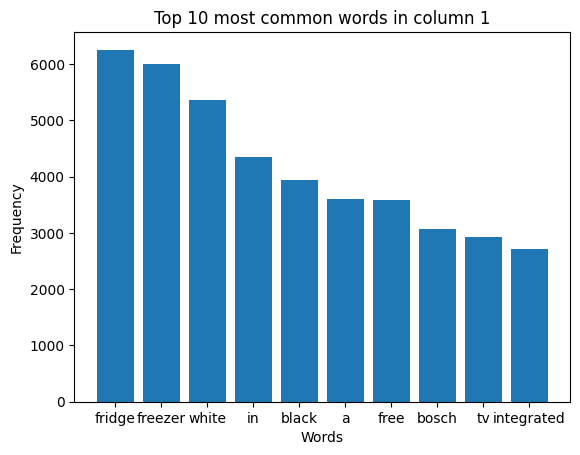

In [15]:
import matplotlib.pyplot as plt
from collections import Counter
import re

# join all texts in column 1 into a single string
text = ' '.join(df.iloc[:, 0].astype(str))

# remove punctuation and convert to lowercase
text = re.sub(r'[^\w\s]', '', text.lower())

# count the frequency of each word
word_freq = Counter(text.split())

# get the top 10 most common words
top_10_words = word_freq.most_common(10)

# plot the bar chart
plt.bar([word[0] for word in top_10_words], [word[1] for word in top_10_words])
plt.title("Top 10 most common words in column 1")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [16]:
# after splitting into train and test set
# Report the sizes of the split datasets
print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_test: {X_test.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of y_test: {y_test.shape}")

Size of X_train: (28248,)
Size of X_test: (7063,)
Size of y_train: (28248,)
Size of y_test: (7063,)


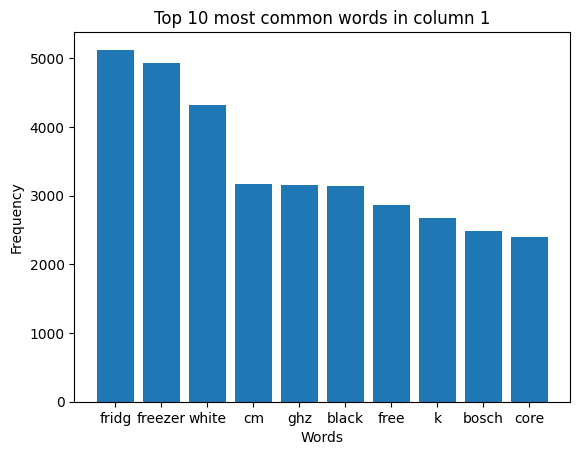

In [17]:
# after appliying preprocess text
# train set
# join all texts in column 1 into a single string
text = ' '.join(X_train_clean.astype(str))

# remove punctuation and convert to lowercase
text = re.sub(r'[^\w\s]', '', text.lower())

# count the frequency of each word
word_freq = Counter(text.split())

# get the top 10 most common words
top_10_words = word_freq.most_common(10)

# plot the bar chart
plt.bar([word[0] for word in top_10_words], [word[1] for word in top_10_words])
plt.title("Top 10 most common words in column 1")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

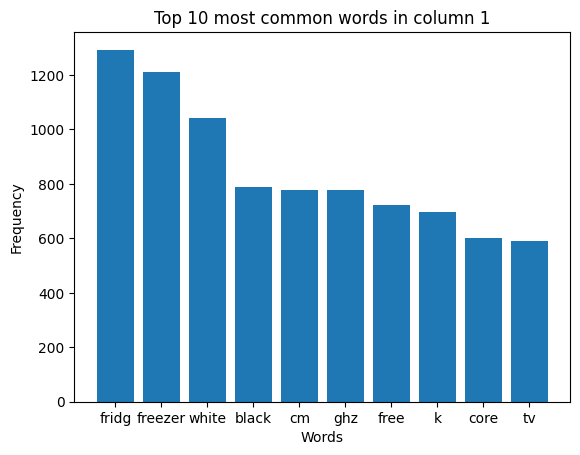

In [18]:
# after appliying preprocess text
# train set
# join all texts in column 1 into a single string
text = ' '.join(X_test_clean.astype(str))

# remove punctuation and convert to lowercase
text = re.sub(r'[^\w\s]', '', text.lower())

# count the frequency of each word
word_freq = Counter(text.split())

# get the top 10 most common words
top_10_words = word_freq.most_common(10)

# plot the bar chart
plt.bar([word[0] for word in top_10_words], [word[1] for word in top_10_words])
plt.title("Top 10 most common words in column 1")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [19]:
# Summary statistics for the preprocessed X sets

# Train set
# create a Series containing the length of each text
text_lengths = X_train_clean.str.len()

# print summary statistics of the text length
print("Summary statistics of text length in the preprocessed X_train:")
print(text_lengths.describe())

# Test set
# create a Series containing the length of each text
text_lengths = X_test_clean.str.len()

# print summary statistics of the text length
print("Summary statistics of text length in the preprocessed X_train:")
print(text_lengths.describe())

Summary statistics of text length in the preprocessed X_train:
count    28248.000000
mean        40.984388
std         17.893052
min          2.000000
25%         30.000000
50%         40.000000
75%         51.000000
max        173.000000
Name: 0, dtype: float64
Summary statistics of text length in the preprocessed X_train:
count    7063.000000
mean       41.302138
std        18.153992
min         3.000000
25%        30.000000
50%        40.000000
75%        51.000000
max       171.000000
Name: 0, dtype: float64


In [20]:
# Size of sets after vectorizing
print(f'Size of the vectorized x_train {X_train.shape}')
print(f'Size of the vectorized x_test {X_test.shape}')

Size of the vectorized x_train (28248,)
Size of the vectorized x_test (7063,)


In [21]:
# some models only accept numeric categories
# Verify the unique classes in y
print(np.unique(y_train))
print(np.unique(y_test))
print(np.unique(y_train_le))
print(np.unique(y_test_le))

['CPUs' 'Digital Cameras' 'Dishwashers' 'Freezers' 'Fridge Freezers'
 'Fridges' 'Microwaves' 'Mobile Phones' 'TVs' 'Washing Machines']
['CPUs' 'Digital Cameras' 'Dishwashers' 'Freezers' 'Fridge Freezers'
 'Fridges' 'Microwaves' 'Mobile Phones' 'TVs' 'Washing Machines']
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


## VIII. Model Building and Evaluation

In [ ]:
# import xgboost as xgb
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# # Define the model
# xgb_model = xgb.XGBClassifier()

# # Define hyperparameters to tune
# param_grid = {
#     'n_estimators': [50], #[50, 100],
#     'max_depth': [5], #[3, 4, 5],
#     'learning_rate': [0.01]
# }

# # Define cross-validation strategy
# cv = StratifiedKFold(n_splits=5)

# # Define grid search
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy')

# # Fit the model on the training data
# grid_search.fit(x_train_svd, y_train_le)

# # Get the best hyperparameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Train the final model with the best hyperparameters on the full training set
# xgb_model = xgb.XGBClassifier(**best_params)
# xgb_model.fit(x_train_svd, y_train_le)

# # Predict on the test set and evaluate accuracy
# y_pred = xgb_model.predict(x_test_svd)
# accuracy = accuracy_score(y_test_le, y_pred)
# print('Accuracy:', accuracy)


In [ ]:

# from sklearn import svm
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# # Define the model
# svm_model = svm.SVC()

# # Define hyperparameters to tune
# param_grid = {
#     'C': [0.1], #[0.1, 1, 10],
#     'kernel': ['linear'], #['linear', 'rbf'],
#     'gamma': ["auto"] #['scale', 'auto']
# }

# # Define cross-validation strategy
# cv = StratifiedKFold(n_splits=5)

# # Define grid search
# grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=cv, scoring='accuracy')

# # Fit the model on the training data
# grid_search.fit(x_train_svd, y_train_le)

# # Get the best hyperparameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Train the final model with the best hyperparameters on the full training set
# svm_model = svm.SVC(**best_params)
# svm_model.fit(x_train_svd, y_train_le)

# # Predict on the test set and evaluate accuracy
# y_pred = svm_model.predict(x_test_svd)
# accuracy = accuracy_score(y_test_le, y_pred)
# print('Accuracy:', accuracy)


In [ ]:
'''
from keras.layers import BatchNormalization

# Reshape input to have a third dimension for conv1d
x_train_nn = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_nn = x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)

# Define the input shape
input_shape = x_train_nn.shape[1:]

num_categories = y_train_ohe.shape[1]

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_categories, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_nn, y_train_ohe, epochs=5)

# Evaluate on test data
model.evaluate(x_test_nn, y_test_ohe)
'''

"\nfrom keras.layers import BatchNormalization\n\n# Reshape input to have a third dimension for conv1d\nx_train_nn = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)\nx_test_nn = x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)\n\n# Define the input shape\ninput_shape = x_train_nn.shape[1:]\n\nnum_categories = y_train_ohe.shape[1]\n\n# Create the model\nmodel = tf.keras.Sequential([\n    tf.keras.layers.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),\n    tf.keras.layers.Dense(32, activation='relu'),\n    tf.keras.layers.Dense(num_categories, activation='softmax')\n])\n\n# Compile and train the model\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\nmodel.fit(x_train_nn, y_train_ohe, epochs=5)\n\n# Evaluate on test data\nmodel.evaluate(x_test_nn, y_test_ohe)\n"

In [22]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Model with cosine similarity as distance measure
knn_model = KNeighborsClassifier(metric='cosine')

# Define hyperparameters to tune
param_grid = {
    'n_neighbors': [3],     #[3, 5, 7, 9],
    'weights': ['uniform']  #['uniform', 'distance']
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Define grid search
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=cv, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(x_train_svd, y_train_le)

# Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the final model with the best hyperparameters on the full training set
knn_model = KNeighborsClassifier(metric='cosine', **best_params)
knn_model.fit(x_train_svd, y_train_le)

print(f"variant: {variant_sm}")
# Predict on the test set and evaluate accuracy
y_pred_train = knn_model.predict(x_train_svd)
accuracy = accuracy_score(y_train_le, y_pred_train)
f1 = f1_score(y_train_le, y_pred_train, average='macro')
print('Train Accuracy:', accuracy)
print('Train F1:', f1)

# Predict on the test set and evaluate accuracy
y_pred = knn_model.predict(x_test_svd)
accuracy = accuracy_score(y_test_le, y_pred)
f1 = f1_score(y_test_le, y_pred, average='macro')
print('Accuracy:', accuracy)
print('Test F1:', f1)

variant: btc
Train Accuracy: 0.970971396205041
Train F1: 0.9699587027207714
Accuracy: 0.9310491292651848
Test F1: 0.9278268632230349


In [23]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Model with default hyperparameters
tree_model = DecisionTreeClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth':  [9], #[3, 5, 7, 9],
    'min_samples_split': [10], #[2, 5, 10],
    'min_samples_leaf': [1] #[1, 2, 4]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Define grid search
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=cv, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(x_train_svd, y_train_le)

# Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the final model with the best hyperparameters on the full training set
tree_model = DecisionTreeClassifier(**best_params)
tree_model.fit(x_train_svd, y_train_le)

print(f"variant: {variant_sm}")
# Predict on the training set and evaluate accuracy
y_pred_train = tree_model.predict(x_train_svd)
accuracy = accuracy_score(y_train_le, y_pred_train)
f1 = f1_score(y_train_le, y_pred_train, average='macro')
print('Train Accuracy:', accuracy)
print('Train F1:', f1)

# Predict on the test set and evaluate accuracy
y_pred = tree_model.predict(x_test_svd)
accuracy = accuracy_score(y_test_le, y_pred)
f1 = f1_score(y_test_le, y_pred, average='macro')
print('Train Accuracy:', accuracy)
print('Train F1:', f1)


variant: btc
Train Accuracy: 0.8347847635230813
Train F1: 0.840743973888151
Train Accuracy: 0.8268441172306386
Train F1: 0.8304145093338251


In [24]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [25]:
# final models
# neural network
# Define output layer for all the labels
num_categories = y_train_ohe.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(num_categories, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train_svd, y_train_ohe, epochs=5)

# Training accuracy
y_pred_train = model.predict(x_train_svd)

# Convert one-hot encoded y_pred to integers
y_pred_train_labels = np.argmax(y_pred_train, axis=1)

print(f"variant: {variant_sm}")
# Evaluate on test data
accuracy = accuracy_score(y_train_le, y_pred_train_labels)
f1 = f1_score(y_train_le, y_pred_train_labels, average='macro')

print(f'Training Accuracy: {accuracy}')
print(f'Training F1 score: {f1}')

# Make predictions on test data
y_pred = model.predict(x_test_svd)

# Convert one-hot encoded y_pred to integers
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate on test data
accuracy = accuracy_score(y_test_le, y_pred_labels)
f1 = f1_score(y_test_le, y_pred_labels, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')

Epoch 1/5
883/883 [==============================] - 9s 4ms/step - loss: 1.4855 - accuracy: 0.7747
Epoch 2/5
883/883 [==============================] - 3s 3ms/step - loss: 0.9260 - accuracy: 0.9236
Epoch 3/5
883/883 [==============================] - 3s 3ms/step - loss: 0.8038 - accuracy: 0.9321
Epoch 4/5
883/883 [==============================] - 3s 3ms/step - loss: 0.7321 - accuracy: 0.9363
Epoch 5/5
883/883 [==============================] - 1s 2ms/step
variant: btc
Training Accuracy: 0.9453058623619371
Training F1 score: 0.947110814823642
221/221 [==============================] - 0s 2ms/step
Accuracy: 0.9402520175562792
F1 score: 0.9417874876708628


In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define the model
nb_model = GaussianNB()

# Define hyperparameters to tune
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Define grid search
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=cv, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(x_train_svd, y_train_le)

# Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the final model with the best hyperparameters on the full training set
nb_model = GaussianNB(**best_params)
nb_model.fit(x_train_svd, y_train_le)

print(f"variant: {variant_sm}")
# Training Accuracy
y_pred_train = nb_model.predict(x_train_svd)
accuracy = accuracy_score(y_train_le, y_pred_train)
f1 = f1_score(y_train_le, y_pred_train, average='macro')
print(f'Training Accuracy: {accuracy}')
print(f'Training F1 score: {f1}')

# Predict on the test set and evaluate accuracy
y_pred = nb_model.predict(x_test_svd)
accuracy = accuracy_score(y_test_le, y_pred)
f1 = f1_score(y_test_le, y_pred, average='macro')
print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')

variant: btc
Training Accuracy: 0.735981308411215
Training F1 score: 0.7364126416459456
Accuracy: 0.7295766671386097
F1 score: 0.7307055849380919
